# Content

- Learn enough HTML to get by
- Scrape some data...
- ... and turn it into information
- Clean the Data to get more accurate information

## HTML

### Webpages

The original tutorial can be found here:
- https://realpython.com/python-web-scraping-practical-introduction/

The site containing a list of mathematicians can be found here:
- http://www.fabpedigree.com/james/mathmen.htm

The site we will use for ranking the mathematicians can be found here:
- https://xtools.wmflabs.org/articleinfo/en.wikipedia.org

### Inspect

Let's look at the mathematician page first.

Notice that the names of the top 100 mathematicians are listed front and center. So let's use the inspect tool in your browser to take a look under the hood.

Inspecting Isaac Newton we get this:

<img src = 'Isaac Newton HTML.png'>

Notice the `<li>` on the line above. In HTML lingo this means `link`, i.e. you can click it and it (should) take you somewhere.

If we look at the rest of the names we can see that all the names have a `link`. In each `link` there is an `a` attribute with some text. Let's scrape all the names from this list.

### Scrape

To scrape the names we're going to need a couple packages.
- `requests`
    - for requesting a connection to the website and grabbing a copy of the html
- `contextlib`
    - for closing the connection
- `BeautifulSoup`
    - for parsing the HTML (a.k.a. the "soup")

In [1]:
import requests
from contextlib import closing
from bs4 import BeautifulSoup

Now that we've got some tools, let's give them some work to do.

#### Names

In [2]:
# save the mathematician address as `url`
url = 'http://www.fabpedigree.com/james/mathmen.htm'

In [3]:
# set up a session
rs = requests.session()

In [4]:
# get the html
result = rs.get(url)

# were we successful?
print(result.status_code, result.ok)

200 True


In [5]:
# close the session, we got what we needed
rs.close()

In [6]:
# parse the html so we can extract from it
soup = BeautifulSoup(result.content, 'html.parser')

In [7]:
for i, li in enumerate(soup.select('li')):
    print(i, li.text)

0  Isaac Newton
 Archimedes
 Carl F. Gauss
 Leonhard Euler
 Bernhard Riemann

1  Archimedes
 Carl F. Gauss
 Leonhard Euler
 Bernhard Riemann

2  Carl F. Gauss
 Leonhard Euler
 Bernhard Riemann

3  Leonhard Euler
 Bernhard Riemann

4  Bernhard Riemann

5  Henri Poincaré
 Joseph-Louis Lagrange
 Euclid  of Alexandria
 David Hilbert
 Gottfried W. Leibniz

6  Joseph-Louis Lagrange
 Euclid  of Alexandria
 David Hilbert
 Gottfried W. Leibniz

7  Euclid  of Alexandria
 David Hilbert
 Gottfried W. Leibniz

8  David Hilbert
 Gottfried W. Leibniz

9  Gottfried W. Leibniz

10  Alexandre Grothendieck
 Pierre de Fermat
 Évariste Galois
 John von Neumann
 Niels Abel

11  Pierre de Fermat
 Évariste Galois
 John von Neumann
 Niels Abel

12  Évariste Galois
 John von Neumann
 Niels Abel

13  John von Neumann
 Niels Abel

14  Niels Abel

15  Karl W. T. Weierstrass
 René Descartes
 Peter G. L. Dirichlet
 Srinivasa Ramanujan
 Carl G. J. Jacobi

16  René Descartes
 Peter G. L. Dirichlet
 Srinivasa Ramanujan

Great! We've successfully pulled in the HTML and found the names on the list... But they look kind of odd. For example, it appears that the names come in groups, or rather, columns. We still need to get individual names rather than column groupings.

Let's do a double for-loop to drill down to the names.

In [8]:
# %%timeit
names = set() # create a set for holding the names. This keeps them unique
for li in soup.select('li'): # loop through the links
    for name in li.text.split('\n'): # split up each column into a list
        if len(name) > 0: # don't look at blanks
            names.add(name.strip()) # strip leading and trailing whitespace
names = list(names)

Or if you wanna be super cool like me you can make a double list-comprehension (not for beginners!!!)

In [9]:
# %%timeit
names = list({name.strip() for li in soup.select('li') for name in li.text.split('\n') if len(name) > 0})

#### Page Views

Now we've got a list of names, let's feed them into the analytics site for Wikipedia.

Let's start with the first name in our list.

In [10]:
names[0]

'Diophantus  of Alexandria'

Go to the site and copy/paste the name into the "Page title" field like this:

<img src = 'Thales of Miletus Analytics.png'>

Hit submit and the next page should look like this:

<img src = 'Thales of Miletus Analytics(1).png'>

Now do that "inspect" thing again on the **Pageviews (60 days):** value:

<img src = 'Thales of Miletus Pageviews.png'>

This one is kind of tricky. We want the value associated to the **Pageviews** but it isn't exactly called out individually.

Looking closely you can see the `a` next to `href`. We want those, and we'll get them in similar way that we got the names.

In [11]:
# new site calls for new url
url = 'https://xtools.wmflabs.org/articleinfo/en.wikipedia.org/Thales%20%20of%20Miletus'

In [12]:
# and a new session
rs = requests.session()

In [13]:
# request the new site
result = rs.get(url)

In [14]:
# were we successful?
print(result.status_code, result.ok)

200 True


In [15]:
# close the session
rs.close()

In [16]:
# parse the HTML
soup = BeautifulSoup(result.content, 'html.parser')

In [17]:
# store the `a` tags as views
views = [a for a in soup.select('a') if a['href'].find('latest-60') > -1]

In [18]:
# see if we got anything
len(views)

1

In [19]:
int(views[0].text.replace(',', ''))

48952

Sweet! It worked. Now we have to do this for the other 99 names... Joy.

Now this is where Python is going to shine.

### User Defined Functions and Classes

A user defined function is literally a function that the user created. For example, we have to scrape a couple (plus 99) different websites and each time we have to use the same code. So instead of writing out the few exact same lines of code every time, why don't we write them once and give it a name? This is the exact same as algebra (you starting to see why we're looking at mathematicians?)

A lot of the times in math we use the notation $f(x)$ to mean a function where $x$ is the input and $f$ is the function. Python can do the exact same thing, but of course we'll name the functions intelligently instead of just using $f$.

Let's start by creating a function for scraping a webpage.

#### Scraper

In [20]:
def scraper(url):
    """
    Takes a URL as input and returns the HTML.
    """
#     start the session
    rs = requests.session()
#     request the site
    result = rs.get(url)
#     close the session
    rs.close()
#     continue if we were successful
    if result.status_code == 200:
        return result.content

We can now test the function on the site with all the mathematician names.

In [21]:
soup = BeautifulSoup(scraper('http://www.fabpedigree.com/james/mathmen.htm'), 'html.parser')

In [22]:
names = list({name.strip() for li in soup.select('li') for name in li.text.split('\n') if len(name) > 0})

In [23]:
len(names)

100

In [24]:
names[0]

'Diophantus  of Alexandria'

Looks the function worked and we still get the same list of names.

Does the function work on our analytics site? Let's check.

In [25]:
soup = BeautifulSoup(scraper('https://xtools.wmflabs.org/articleinfo/en.wikipedia.org/David%20Hilbert'), 'html.parser')

In [26]:
# store the `a` tags as views
views = [a for a in soup.select('a') if a['href'].find('latest-60') > -1]

In [27]:
int(views[0].text.replace(',', ''))

42955

It works!!! Now, we still haven't really solved the problem of doing this 99 more times; we just reduced 4 lines of scraping code into one function. What we need now is a for-loop of sorts to search the analytics site for each name in our mathematician list. But how can we do this without physically typing it into the search bar? Let's have a look at the URL.

Here is the original URL:
- https://xtools.wmflabs.org/articleinfo/en.wikipedia.org

And here is the one after searching for one of the names:
- https://xtools.wmflabs.org/articleinfo/en.wikipedia.org/David%20Hilbert

Notice a difference?

If you don't, we can use Python to show it to you.

In [28]:
original_url = 'https://xtools.wmflabs.org/articleinfo/en.wikipedia.org'

In [29]:
new_url = 'https://xtools.wmflabs.org/articleinfo/en.wikipedia.org/David%20Hilbert'

In [30]:
new_url.replace(original_url, '')

'/David%20Hilbert'

- The `/` indicates that we're going to search the website for what follows
- The `%20` is HTML lingo for a space. Sometimes you might also see a `+`
    - For our purpose we don't need to worry about this because the browser will automatically convert our spaces into the necessary format.

So let's open up the browser and see if we can just type in the name we want in the search bar after the url to get the same result.

<img src = 'David Hilbert Search.png'>

Hit enter and the browser should have converted the link to this:

<img src = 'David Hilbert Search(1).png'>

and take you to the same page we've seen before!

Now that we know how to go directly to the needed webpage, let's make another function that will give us just the number of pageviews

#### Pageviews

In [31]:
def pageviews(name):
#     format the original url with the name
    url = 'https://xtools.wmflabs.org/articleinfo/en.wikipedia.org/{}'.format(name)
#     scrape the page
    soup = BeautifulSoup(scraper(url), 'html.parser')
#     grab the `a` tag with pageviews
    views = [a for a in soup.select('a') if a['href'].find('latest-60') > -1]
#     return the pageviews as an integer
    return int(views[0].text.replace(',', ''))

In [32]:
for name in names:
    print(name, pageviews(name))

Diophantus  of Alexandria 234
Jakob Steiner 2108
Alan M. Turing 312


IndexError: list index out of range

Uh oh! Looks like something broke. This is the part of learning how to code that can make people tear their hair out... debugging.

Looking at our results that came out before the error, we can see that code is working correctly (at least for those names). So let's look at the first name it didn't work for.

##### Step 1.

Find out which name it is.

In [33]:
for i, name in enumerate(names):
    print(i, name, pageviews(name))

0 Diophantus  of Alexandria 234
1 Jakob Steiner 2108
2 Alan M. Turing 312


IndexError: list index out of range

Notice that the numbers start at 0. This is because Python is zero-indexed. This means that the function broke on the $6th$ name, which is index number $5$. Let's see who that is.

In [34]:
names[5]

'Aryabhata'

##### Step 2.

Run through the function line-by-line and find out where it breaks.

In [35]:
url = 'https://xtools.wmflabs.org/articleinfo/en.wikipedia.org/Karl W. T. Weierstrass'

In [36]:
soup = BeautifulSoup(scraper(url), 'html.parser')

In [37]:
views = [a for a in soup.select('a') if a['href'].find('latest-60') > -1]

In [38]:
int(views[0].text.replace(',', ''))

IndexError: list index out of range

Congratulations! You've found where the error occurred. But what's happening? Let's break this line down into it's pieces starting with the original `views`.

In [41]:
views

[]

There's our problem right there. `views` is supposed to be a list containing the HTML that holds the pageviews. But apparently this name didn't return any. Hmmmm... Let's search the url and see what the webpage looks like.

<img src = 'Karl W. T. Weierstrass Search.png'>

<img src = 'Karl W. T. Weierstrass Result.png'>

Ah. Wikipedia appears to have nothing on this "Top 100" Mathematician. Strange.

##### Step 3.

To fix the problem we'll just add some logic to our function to handle cases like these.

In [42]:
def pageviews(name):
#     format the original url with the name
    url = 'https://xtools.wmflabs.org/articleinfo/en.wikipedia.org/{}'.format(name)
#     scrape the page
    soup = BeautifulSoup(scraper(url), 'html.parser')
#     grab the `a` tag with pageviews
    views = [a for a in soup.select('a') if a['href'].find('latest-60') > -1]
#     add logic to make sure we have pageviews
    if len(views) > 0:
#         return the pageviews as an integer
        return int(views[0].text.replace(',', ''))

Let's see if the function works.

In [43]:
for name in names:
    print(name, pageviews(name))

Diophantus  of Alexandria 234
Jakob Steiner 2108
Alan M. Turing 312
James J. Sylvester None
James C. Maxwell 86
Aryabhata 114874
Pythagoras  of Samos 438
F. Gotthold Eisenstein None
Stefan Banach 10926
Felix Christian Klein 44
John von Neumann 135070
Girolamo Cardano 835
Jean-Pierre Serre 8200
F.E.J. Émile Borel None
Christiaan Huygens 41115
Euclid  of Alexandria 370
Eudoxus  of Cnidus 7057
Jean le Rond d'Alembert 11921
Alhazen ibn al-Haytham None
Blaise Pascal 102805
Alfred Tarski 10907
L.E.J. Brouwer 340
F. L. Gottlob Frege None
Charles Hermite 4279
Bháscara (II) Áchárya None
Henri Léon Lebesgue 33
Shiing-Shen Chern 8883
Adrien M. Legendre None
Atle Selberg 2197
Peter G. L. Dirichlet None
Carl F. Gauss 53
Johann H. Lambert 13
Hermann G. Grassmann None
Godfrey H. Hardy 7
Julius Plücker 2146
Leonhard Euler 110153
Giuseppe Peano 5887
Carl G. J. Jacobi 6
Élie Cartan 4758
Joseph-Louis Lagrange 23939
Jacques Hadamard 4544
Felix Hausdorff 3638
Gaspard Monge 6767
Muhammed al-Khowârizmi None


No errors! The function works. So now let's store the names and their page views in a analyzable structure, i.e. a data frame.

## Analyze

We'll use `pandas`, Python's data analysis library.

In [44]:
import pandas as pd

In [45]:
df = pd.DataFrame([
    (name, pageviews(name)) for name in names # use list comprehension and tuple to produce formattable data
], columns = [ # name the columns within the function
    'mathematician',
    'pageviews'
])

Now we've got a data frame, let's analyze it a bit. Here's your first question:
1. Who is the most popular mathematician in our list based on pageviews?

In [46]:
df.sort_values('pageviews', ascending = False).head(1)

,mathematician,pageviews
82,Albert Einstein,1073992.0


Looks like Albert Einstein takes the prize as most popular with $1,095,954$ pageviews. That sounds pretty accurate. What about the least popular (not including nulls)?

In [47]:
df.sort_values('pageviews').head(1)

,mathematician,pageviews
69,Andrey N. Kolmogorov,1.0


Andrey N. Kolmogorov. Judging by the last name I'd say he's a Russian mathematician. Let's visit our mathematician webpage and see what he did that makes him "not so popular".

<img src = 'Andrey N. Kolmogorov Bio.png'>

It looks like Andrey did a lot of work in multiple fields of Math. So why does he only have one pageview? This might be worth investigating...

Let's take a look at some of the mathematicians who had no pageviews.

In [48]:
df.loc[df.pageviews.isnull()]

,mathematician,pageviews
3,James J. Sylvester,NaN
7,F. Gotthold Eisenstein,NaN
13,F.E.J. Émile Borel,NaN
18,Alhazen ibn al-Haytham,NaN
22,F. L. Gottlob Frege,NaN
24,Bháscara (II) Áchárya,NaN
27,Adrien M. Legendre,NaN
29,Peter G. L. Dirichlet,NaN
32,Hermann G. Grassmann,NaN
43,Muhammed al-Khowârizmi,NaN


A little back story on me. I have a B.S. in Mathematics from Kansas State University. While I was there (and before) I used to read all the little history blurbs in every math textbook I received because I thought they gave more context to the problems I was solving. They also gave me motivation to continue pushing through obstacles.

Because I loved these little history blurbs so much, I ended up taking a History of Mathematics course (which is not dry/dull at all and actually contains a lot of hidden reasons as to how we got to where we are today). There were duels to the death, assassinations, wars, code breakers, and mad scientists. 

This class was so enjoyable that I still remember several famous mathematicians' names and what they did. Which leads me to my point: there is no way that Muhammed al-Khowârizmi, Leonardo Fibonacci', or Gottfried W. Leibniz (to name a few) have no pageviews.

In data science (and other fields), this is called having *domain knowledge*.

Let's look at these names and see if we can find a pattern; something that they all have that the other (pageviews > 0) mathematicians don't.

We'll start with some graphs to see if we can't trace something out.

Also, let's fill our `NaN` values in the pageviews with 0 since we know they don't have any (yet).

There are two ways to do this.
- you can fill any na with $0$ like this:

- or you can limit to a specific subset

Since we know pageviews is the only column with `NaN` we can use the first method.

In [49]:
df.fillna(0, inplace = True)

In [50]:
# this allows you to see your plots "inline"
%matplotlib inline

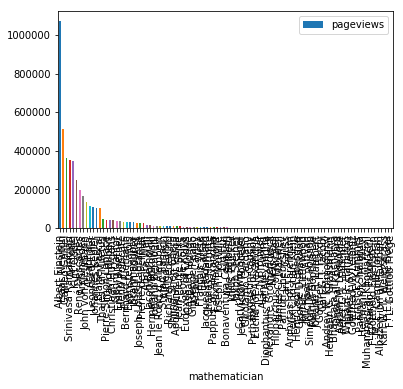

In [51]:
df.sort_values('pageviews', ascending = False).plot.bar(x = 'mathematician', y = 'pageviews');

This is going to be an odd observation to make (and probably unorthodox), but if you look "outside the box", you can see that the names on the x-axis start get a little longer as the pageviews decrease. If you don't believe me, let's graph it.

First, we have to create a new column that contains the length of the mathematicians' names.

In [52]:
df['name_len'] = df.mathematician.str.len()

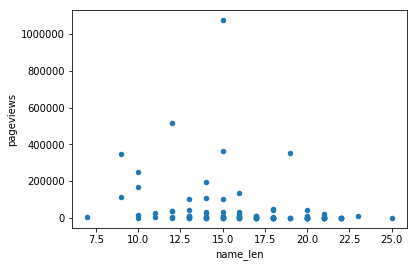

In [53]:
df.plot.scatter(x = 'name_len', y = 'pageviews');

This is a very rough looking scatter plot and probably has very little to no correlation between name length and pageviews, but it's enough to make you dig further. For example, what if we compared the number of spaces in a name to pageviews? For example,
- Albert Einstein has 1 space,
- but Andrey N. Kolmogorov has 2 spaces.

To graph it we'll need another new column.

In [54]:
df['name_space'] = df.mathematician.str.count(' ')

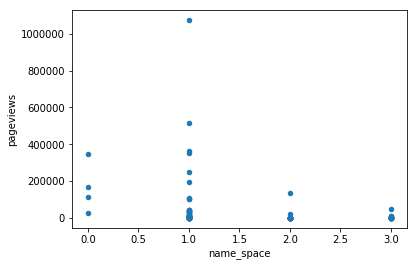

In [55]:
df.plot.scatter(x = 'name_space', y = 'pageviews');

I think we're on to something.

- Mathematicians with no spaces (i.e. they only have a first name) have a pretty high number of pageviews.
- Mathematicians with 1 space (i.e. a first and a last name) also have pretty high number of pageviews.
- If you move beyond that to 2 and 3 spaces, the pageviews drop quite a bit.

Let's get a unique count of mathematicians in each group and the average number of pageviews.

In [56]:
df.groupby('name_space').agg({
    'mathematician' : pd.Series.nunique,
    'pageviews' : 'mean'
})

,mathematician,pageviews
name_space,,
0,4,164742.750000
1,54,66454.888889
2,25,6462.840000
3,17,4788.352941


Ah ha! Some more evidence. This table shows that just over half of our mathematicians have one space in their name and (on average) get about $66,000$ pageviews. Then the average number of pageviews drops quite a bit down to $6,000$ with a quarter of the mathematicians having two spaces, and even more with three space (just under one-fifth of the mathematicians with about $4,700$ pageviews).

Let's take a look at the distribution of pageviews for each `name_space` group to make sure the mean is a good representation.

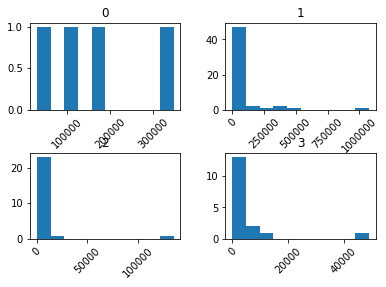

In [57]:
df.pageviews.hist(by = df.name_space, xrot = 45);

Okay so maybe the mean isn't such a good representation since these distributions look rather skewed. What about the mean?

In [58]:
df.groupby('name_space').agg({
    'mathematician' : pd.Series.nunique,
    'pageviews' : [
        'mean',
        'median'
    ]
})

mathematician      pageviews          
                 nunique           mean    median
name_space                                       
0                      4  164742.750000  141209.5
1                     54   66454.888889    8541.5
2                     25    6462.840000      13.0
3                     17    4788.352941     108.0

The median looks like a MUCH better description of each groups' pageviews, and it affirms our thought that there is a relation between the number of spaces in a name and the number of pageviews.

Now that we've drilled down a bit, let's take a closer look at mathematicians who have $> 1$ space in their names.

In [59]:
# filter down to name_space > 1
gt1 = df.loc[df.name_space > 1].copy()

Let's confirm that we have 42 mathematicians (25 + 17).

In [60]:
gt1.mathematician.nunique()

42

Check. Now let's look at the names.

In [61]:
gt1.mathematician

0     Diophantus  of Alexandria
2                Alan M. Turing
3            James J. Sylvester
4              James C. Maxwell
6          Pythagoras  of Samos
7        F. Gotthold Eisenstein
9         Felix Christian Klein
10             John von Neumann
13           F.E.J. Émile Borel
15        Euclid  of Alexandria
16           Eudoxus  of Cnidus
17      Jean le Rond d'Alembert
18       Alhazen ibn al-Haytham
22          F. L. Gottlob Frege
24        Bháscara (II) Áchárya
25          Henri Léon Lebesgue
27           Adrien M. Legendre
29        Peter G. L. Dirichlet
30                Carl F. Gauss
31            Johann H. Lambert
32         Hermann G. Grassmann
33             Godfrey H. Hardy
37            Carl G. J. Jacobi
49           Carl Ludwig Siegel
55           Thales  of Miletus
56        Hipparchus  of Nicaea
57         Apollonius  of Perga
59            Marius Sophus Lie
61           George D. Birkhoff
62             Pierre de Fermat
63       Karl W. T. Weierstrass
69      

We've already stated that each name in this list has $> 1$ spaces. What else do you see?

- some have periods after initials
- some have the word "of"
- some have accented characters
- some have parentheses

Let's get a list of the unique characters in each name.

To make sure we don't duplicate letters, let's make everything lowercase.

In [62]:
gt1['name_lower'] = gt1.mathematician.str.lower()

And for good measure let's remove the spaces.

In [63]:
gt1['name_lower_nspace'] = gt1.name_lower.str.replace(' ', '')

To get all the unique characters we can simply `sum()` the column and then convert it to a `set` which by default keeps only unique characters.

In [64]:
set(gt1.name_lower_nspace.sum())

{"'",
 '(',
 ')',
 '-',
 '.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'á',
 'é'}

Next we're gonna do something kind of weird: turn all the values into a columns. Why? Because if we have a column for each unique value, we can then put a `1` in the cell associated with a mathematician if the value is present and `NaN` if it is not.

In [65]:
unique_chars = set(gt1.name_lower_nspace.sum())

In [66]:
# join the columns with the names
gt1_2 = gt1.join(pd.DataFrame(columns = sorted(list(unique_chars)))).copy()

In [67]:
# limit to reduced name and characters
char_in = gt1_2.loc[:, 'name_lower_nspace':].copy()

In [68]:
# melt the frame
char_in1 = char_in.melt(id_vars = 'name_lower_nspace', var_name = 'char').copy()

In [69]:
# check if the character is in the name
char_in1.value = char_in1.apply(lambda x : 1 if x.char in x.name_lower_nspace else float('nan'), axis = 1).copy()

In [70]:
# drop the `NaN`
char_in1.dropna(inplace = True)

In [71]:
# pivot the characters back into columns
char_pivot = char_in1.pivot_table(index = 'name_lower_nspace', columns = 'char', aggfunc = 'sum', margins = True).value.copy()

In [72]:
char_pivot

char,',(,),-,.,a,b,c,d,e,...,t,u,v,w,x,y,z,á,é,All
name_lower_nspace,,,,,,,,,,,,,,,,,,,,,
adrienm.legendre,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
alanm.turing,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
alhazenibnal-haytham,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,...,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,12.0
andreyn.kolmogorov,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,13.0
apolloniusofperga,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
archytasoftarentum,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,...,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,13.0
bháscara(ii)áchárya,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,11.0
carlf.gauss,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
carlg.j.jacobi,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0


Phew! That was a lot of flipping and flopping.

What did we get out of it? Let's see. We added the parameter `margins = True` so we could get row and column sums. This tells us which mathematicians had the most unique characters (probably not that interesting) and which characters were in the most mathematicians (more interesting). Let's take a look at the counts for each character.

In [73]:
char_pivot.loc['All'].sort_values()

char
'        1.0
(        1.0
)        1.0
-        1.0
á        1.0
é        2.0
z        2.0
v        3.0
k        6.0
x        6.0
w        7.0
j        9.0
p        9.0
y        9.0
b       10.0
c       13.0
g       16.0
d       16.0
u       16.0
f       20.0
m       21.0
s       21.0
t       21.0
h       22.0
.       23.0
n       25.0
o       26.0
i       28.0
l       31.0
a       32.0
r       33.0
e       35.0
All    467.0
Name: All, dtype: float64

It appears that only a couple mathematicians have special characters like `'`, `(`, `)`, and `-`. But quite a few have a `.`. In fact, just over half of the mathematicians on this list have a `.` in their name. What does a `.` signify? Let's filter the data and find out.

In [84]:
# have to use escape character to search for some symbols. `.` appears to be one of them
gt1_period = gt1.loc[gt1.mathematician.str.contains('\.')].copy()

In [85]:
gt1_period

,mathematician,pageviews,name_len,name_space,name_lower,name_lower_nspace
2,Alan M. Turing,312.0,14,2,alan m. turing,alanm.turing
3,James J. Sylvester,0.0,18,2,james j. sylvester,jamesj.sylvester
4,James C. Maxwell,86.0,16,2,james c. maxwell,jamesc.maxwell
7,F. Gotthold Eisenstein,0.0,22,2,f. gotthold eisenstein,f.gottholdeisenstein
13,F.E.J. Émile Borel,0.0,18,2,f.e.j. émile borel,f.e.j.émileborel
22,F. L. Gottlob Frege,0.0,19,3,f. l. gottlob frege,f.l.gottlobfrege
27,Adrien M. Legendre,0.0,18,2,adrien m. legendre,adrienm.legendre
29,Peter G. L. Dirichlet,0.0,21,3,peter g. l. dirichlet,peterg.l.dirichlet
30,Carl F. Gauss,53.0,13,2,carl f. gauss,carlf.gauss
31,Johann H. Lambert,13.0,17,2,johann h. lambert,johannh.lambert


Apparently a `.` means a mathematician has an initial in their name. Pretty common.

In [86]:
(gt1_period.pageviews == 0).sum(), (gt1_period.pageviews != 0).sum()

(13, 10)

Another interesting find is that over half of the mathematicians with a `.` in their name have $0$ pageviews. Coincidence? I don't think so...

Now what about the other mathematicians who $0$ pageviews? What's up with them?

In [87]:
gt1.loc[gt1.pageviews == 0].loc[gt1.mathematician.isin(gt1_period.mathematician) == False]

,mathematician,pageviews,name_len,name_space,name_lower,name_lower_nspace
18,Alhazen ibn al-Haytham,0.0,22,2,alhazen ibn al-haytham,alhazenibnal-haytham
24,Bháscara (II) Áchárya,0.0,21,2,bháscara (ii) áchárya,bháscara(ii)áchárya
88,Panini of Shalatula,0.0,20,3,panini of shalatula,paniniofshalatula


Well, well, well... There's kind a combination of special characters here. We've found who has both `(` and `)`, and who has the `-`. These are some interesting finds indeed.

What next? What can we do with these findings? Well to start we could run a couple experiments like removing the `.` and rerunning our scraper, or we could remove the initial completely. If we do this we will need to make sure that we keep copies of every version so we can compare them (easy). AND we need to make sure that the new name we are searching is actually the same person (hard).

Another thing we could do is figure out what the initial actually means (time consuming).

Let's start with removing the `.` in the mathematicians' names and rerunning our `pageviews()` function.

In [88]:
# replacing the `.` with empty space
gt1_period['name_nperiod'] = gt1_period.mathematician.str.replace('.', '').copy()

Before we go running the `pageviews()` function it would be smart to have a place to store the values. We could create a column as we run the function like this:

But this is considered "bad" because it can result in slow processing speeds. It's much better to already have a column filled with `NaN` and then fill it with the values.

In [93]:
# make a `NaN` column for storing the pageviews
gt1_period['pageviews_nperiod'] = float('nan')

In [99]:
gt1_period.pageviews_nperiod = gt1_period.apply(lambda x : pageviews(x.name_nperiod), axis = 1).fillna(0)

It finished running. Let's do a simple comparison between `pageviews` and `pageviews_nperiod`.

In [101]:
gt1_period.loc[:, [
    'mathematician',
    'pageviews',
    'pageviews_nperiod'
]]

,mathematician,pageviews,pageviews_nperiod
2,Alan M. Turing,312.0,0.0
3,James J. Sylvester,0.0,0.0
4,James C. Maxwell,86.0,0.0
7,F. Gotthold Eisenstein,0.0,0.0
13,F.E.J. Émile Borel,0.0,0.0
22,F. L. Gottlob Frege,0.0,0.0
27,Adrien M. Legendre,0.0,0.0
29,Peter G. L. Dirichlet,0.0,0.0
30,Carl F. Gauss,53.0,0.0
31,Johann H. Lambert,13.0,0.0


Hmmm... Looks like a lot of zeros. And when it's not zero the original pageviews were still higher for the most part. What if we just removed the the initials? Let's try it.

First, we're gonna have to figure out how to remove the period and the one letter preceding it.

We've already got a column without the period so let's work with it.

In [122]:
gt1_period.name_nperiod

2             Alan M Turing
3         James J Sylvester
4           James C Maxwell
7     F Gotthold Eisenstein
13          FEJ Émile Borel
22        F L Gottlob Frege
27        Adrien M Legendre
29      Peter G L Dirichlet
30             Carl F Gauss
31         Johann H Lambert
32      Hermann G Grassmann
33          Godfrey H Hardy
37          Carl G J Jacobi
61        George D Birkhoff
63     Karl W T Weierstrass
69      Andrey N Kolmogorov
71           Ernst E Kummer
77        John E Littlewood
80       M E Camille Jordan
81         Michael F Atiyah
87         Hermann K H Weyl
91      Gottfried W Leibniz
93       William R Hamilton
Name: name_nperiod, dtype: object

Giving a quick glance to the column, I'm sensing we're gonna have some obstacles. For example, if we just removed one middle initial, we'd completely anyone who had two middle initials, not to mention those who use initials for their first name. Let's think about this.

What can we do that will encapsulate all scenarios here?

Well, we know that the initials are always capitalized. We also know that the initial is usually preceded and succeeded by a space (`' '`). It looks like there is only one case where the mathematician has three initials with no spaces between them (FEJ Émile Borel). We can find a way to account for that once we get everyone else taken care of.

Let's start by splitting on `' '` and checking the `len` of the strings.

In [208]:
name_split = gt1_period.name_nperiod.str.split(' ', expand = True)

In [209]:
name_split.apply(lambda x : x.str.len())

,0,1,2,3
2,4,1,6,NaN
3,5,1,9,NaN
4,5,1,7,NaN
7,1,8,10,NaN
13,3,5,5,NaN
22,1,1,7,5.0
27,6,1,8,NaN
29,5,1,1,9.0
30,4,1,5,NaN
31,6,1,7,NaN


Looking at this it looks like we could replace the cells that have `len() == 1` and keep everything else. That should solve most of our issues.

In [227]:
name_split.where(cond = name_split.apply(lambda x : x.str.len() > 1), other = '', inplace = True)

In [228]:
name_split

,0,1,2,3
2,Alan,,Turing,
3,James,,Sylvester,
4,James,,Maxwell,
7,,Gotthold,Eisenstein,
13,FEJ,Émile,Borel,
22,,,Gottlob,Frege
27,Adrien,,Legendre,
29,Peter,,,Dirichlet
30,Carl,,Gauss,
31,Johann,,Lambert,


Looking good. Now we have to sum up the names in each row to get back to the full name.

In [238]:
name_split = (name_split + ' ').sum(axis = 1).str.strip().copy()

In [239]:
name_split

2            Alan  Turing
3        James  Sylvester
4          James  Maxwell
7     Gotthold Eisenstein
13        FEJ Émile Borel
22          Gottlob Frege
27       Adrien  Legendre
29      Peter   Dirichlet
30            Carl  Gauss
31        Johann  Lambert
32     Hermann  Grassmann
33         Godfrey  Hardy
37          Carl   Jacobi
61       George  Birkhoff
63     Karl   Weierstrass
69     Andrey  Kolmogorov
71          Ernst  Kummer
77       John  Littlewood
80         Camille Jordan
81        Michael  Atiyah
87         Hermann   Weyl
91     Gottfried  Leibniz
93      William  Hamilton
dtype: object

Great! Now we all have to take care of is "FEJ Émile Borel". Since he's the only one we can do a special edit just for him. Don't worry about the extra spaces between each name; when the `pageviews` function runs the browser will see it as negligible compared to one space.

In [242]:
name_split = name_split.str.replace('FEJ ', '')

In [243]:
name_split

2            Alan  Turing
3        James  Sylvester
4          James  Maxwell
7     Gotthold Eisenstein
13            Émile Borel
22          Gottlob Frege
27       Adrien  Legendre
29      Peter   Dirichlet
30            Carl  Gauss
31        Johann  Lambert
32     Hermann  Grassmann
33         Godfrey  Hardy
37          Carl   Jacobi
61       George  Birkhoff
63     Karl   Weierstrass
69     Andrey  Kolmogorov
71          Ernst  Kummer
77       John  Littlewood
80         Camille Jordan
81        Michael  Atiyah
87         Hermann   Weyl
91     Gottfried  Leibniz
93      William  Hamilton
dtype: object

Perfect. The initials have been removed so now we can put the back in the dataframe.

In [245]:
gt1_period['name_ninitial'] = name_split

In [246]:
gt1_period

,mathematician,pageviews,name_len,name_space,name_lower,name_lower_nspace,name_nperiod,pageviews_nperiod,name_ninitial
2,Alan M. Turing,312.0,14,2,alan m. turing,alanm.turing,Alan M Turing,0.0,Alan Turing
3,James J. Sylvester,0.0,18,2,james j. sylvester,jamesj.sylvester,James J Sylvester,0.0,James Sylvester
4,James C. Maxwell,86.0,16,2,james c. maxwell,jamesc.maxwell,James C Maxwell,0.0,James Maxwell
7,F. Gotthold Eisenstein,0.0,22,2,f. gotthold eisenstein,f.gottholdeisenstein,F Gotthold Eisenstein,0.0,Gotthold Eisenstein
13,F.E.J. Émile Borel,0.0,18,2,f.e.j. émile borel,f.e.j.émileborel,FEJ Émile Borel,0.0,Émile Borel
22,F. L. Gottlob Frege,0.0,19,3,f. l. gottlob frege,f.l.gottlobfrege,F L Gottlob Frege,0.0,Gottlob Frege
27,Adrien M. Legendre,0.0,18,2,adrien m. legendre,adrienm.legendre,Adrien M Legendre,0.0,Adrien Legendre
29,Peter G. L. Dirichlet,0.0,21,3,peter g. l. dirichlet,peterg.l.dirichlet,Peter G L Dirichlet,0.0,Peter Dirichlet
30,Carl F. Gauss,53.0,13,2,carl f. gauss,carlf.gauss,Carl F Gauss,0.0,Carl Gauss
31,Johann H. Lambert,13.0,17,2,johann h. lambert,johannh.lambert,Johann H Lambert,0.0,Johann Lambert


Alright. Let's run the `pageviews()` function again and see if we get any better results.

In [247]:
# make a `NaN` column
gt1_period['pageviews_ninitial'] = float('nan')

In [250]:
gt1_period.pageviews_ninitial = gt1_period.apply(lambda x : pageviews(x.name_ninitial), axis = 1)

In [251]:
gt1_period.pageviews_ninitial

2     506992
3         38
4        739
7       3212
13      3567
22     18938
27         5
29         9
30       786
31       100
32      4001
33        65
37        98
61       394
63     10477
69     16280
71      2898
77        70
80      4520
81     11006
87     10530
91     20973
93      1358
Name: pageviews_ninitial, dtype: int64

These results look VERY promising. Let's do a quick comparison.

In [253]:
gt1_period.loc[:, [
    'mathematician',
    'pageviews',
    'pageviews_nperiod',
    'pageviews_ninitial'
]]

,mathematician,pageviews,pageviews_nperiod,pageviews_ninitial
2,Alan M. Turing,312.0,0.0,506992
3,James J. Sylvester,0.0,0.0,38
4,James C. Maxwell,86.0,0.0,739
7,F. Gotthold Eisenstein,0.0,0.0,3212
13,F.E.J. Émile Borel,0.0,0.0,3567
22,F. L. Gottlob Frege,0.0,0.0,18938
27,Adrien M. Legendre,0.0,0.0,5
29,Peter G. L. Dirichlet,0.0,0.0,9
30,Carl F. Gauss,53.0,0.0,786
31,Johann H. Lambert,13.0,0.0,100


Wow! It looks like Wikipedia actually has a page for every single one of these mathematicians! I knew the original results couldn't be right.